In [493]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [477]:
import numpy as np
import mne
import os
import sys
from mne.datasets import eegbci
import matplotlib.pyplot as plt
from scipy import signal
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
mne.set_log_level('WARNING')

## EEG Motor Movement/Imagery Dataset

1. https://www.physionet.org/content/eegmmidb/1.0.0/
2. Schalk, G., McFarland, D.J., Hinterberger, T., Birbaumer, N., Wolpaw, J.R. BCI2000: A General-Purpose Brain-Computer Interface (BCI) System. IEEE Transactions on Biomedical Engineering 51(6):1034-1043, 2004
3. https://mne.tools/stable/auto_examples/index.html

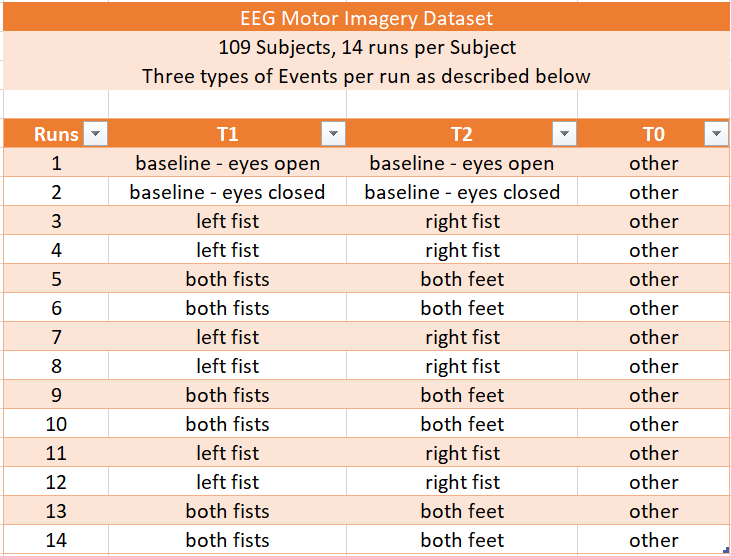

### Defining a motorImagery class for Data Loading and Pre-processing

In [478]:
class motorImagery:
    def __init__(self, path=None, subjects=[1], runs=[1]):
        self.path = path
        self.edf_filenames = self.get_filenames(path)
        self.raw = self.load_eeg(subjects, runs)
        
    def get_filenames(self, path):
        file = open(dataset_path+'RECORDS')
        edf_filenames = file.readlines()
        file.close()
        edf_filenames = [fname.rstrip() for fname in edf_filenames]
        return edf_filenames
    
    def load_eeg(self, subjects, runs):    #load -> standardize -> notch_filter -> bandpass filter -> return
    
        fno = self.get_fileIndices(subjects, runs)
        print('Loading files at index:', fno)
        
        raw_eegs = []
        for idx,i in enumerate(fno):
            path_file = os.path.join(self.path, self.edf_filenames[i])
            sys.stdout.write(f"\rLoading file #{idx+1}/{len(fno)}: {path_file}")
            raw = mne.io.read_raw_edf( path_file , preload=True, verbose='WARNING' )
            raw_eegs.append(raw)

        raw = mne.io.concatenate_raws(raw_eegs)     # Concatenate all EEGs together
        eegbci.standardize(raw)                     # Standardize channel names
        montage = mne.channels.make_standard_montage('standard_1005')
        raw.set_montage(montage)
        return raw                                  
    
    def get_fileIndices(self, subjects, runs):
        fno = []
        subjects = [s-1 for s in subjects]  # start from 0, 1, 2, ...
        for subject in subjects:
            for run in runs:
                fno.append(subject*14+run-1)   # 14 runs per subject
        return fno
    
    def apply_filter(self, freq):
        # Remove power line noise atrifacts at 50 Hz <-- European data so 50Hz powerline freq
        #self.raw.notch_filter(50)
        # Remove higher frequencies as they are redundant for analysis.
        low_freq, high_freq = freq
        self.raw.filter(low_freq, high_freq, fir_design='firwin')
        
    def get_ica(self, n=16):
        self.ica = mne.preprocessing.ICA(n_components=n, max_iter='auto', random_state=97)
        self.ica.fit(self.raw)
        self.raw.load_data()
        self.ica.plot_sources(self.raw)
        self.ica.plot_components()
        
    def exclude_ic(self, channels):
        self.ica.exclude = channels
        self.ica.apply(self.raw)

    def get_events(self):
        event_id = dict(T1=2, T2=3)        # Define the events we want to extract
        events, event_id = mne.events_from_annotations(self.raw, event_id=event_id)
        return events, event_id
    
    def get_epochs(self, events, event_id):
        # We don't need it for now but lets include it as it is a part of the pipeline of eeg classification
        picks = mne.pick_types(self.raw.info, eeg=True, exclude='bads')

        # tmin and tmax are relative to the event onset time. They decide the time interval (relative to event onset) taken to 
        # form the epoch from eeg signal. 
        tmin = -1  # A second before event cue 
        tmax = 4   # Four seconds after cue. Most events are of 4.1 or 4.2 seconds long as described in annotations.

        # Read epochs (only the events described in our event_id will be included for training)
        # For future try to use baseline subtraction method 
        epochs = mne.Epochs(self.raw, events, event_id, tmin, tmax, proj=True, 
                            picks=picks, baseline=None, preload=True)

        # Only eeg signals in time interval 1-2 sec will be used for training -> 1 sec after event cue to 2 sec after cue.
        # This is to avoid the evoked potentials arising in brain in response to event cue.
        epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
        montage = mne.channels.make_standard_montage('standard_1005')
        epochs_train.set_montage(montage)
        
        return epochs_train
    
    def downsample(self, epochs, factor):
        return epochs.decimate(factor)
        
    def return_epochs(self, freq=(1, 35), dsamplingFactor=1, channel_selection=False):
        events, event_id = self.get_events()
        self.epochs = self.get_epochs(events, event_id)
        self.epochs = self.downsample(self.epochs, dsamplingFactor)
        self.labels = self.epochs.events[:,-1] - 2        # Convert from 2,3 to 0,1 and assign to labels for training
        if channel_selection:
            self.epochs = self.epochs.pick_channels(self.epochs.ch_names[:21])
        return self.epochs, self.labels
    
    def get_X_y(self, channel_selection=False):
        self.return_epochs(channel_selection=channel_selection)
        return self.epochs.get_data(), self.labels

#### Loading data using the motorImagery class

In [123]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [479]:
dataset_path = os.path.join("H:\\","BCI Project","eeg-motor-movementimagery-dataset-1.0.0","files\\")
subjects = [1,2,3,4,5,6,7,8,9,10]
runs = [6,10,14]
eeg = motorImagery(dataset_path, subjects, runs)

#eeg.apply_filter(freq=(7,30))
#X, y = eeg.get_X_y()
#X.shape

Loading files at index: [5, 9, 13, 19, 23, 27, 33, 37, 41, 47, 51, 55, 61, 65, 69, 75, 79, 83, 89, 93, 97, 103, 107, 111, 117, 121, 125, 131, 135, 139]
Loading file #30/30: H:\BCI Project\eeg-motor-movementimagery-dataset-1.0.0\files\S010/S010R14.edf

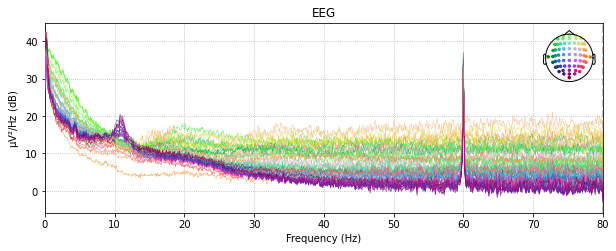

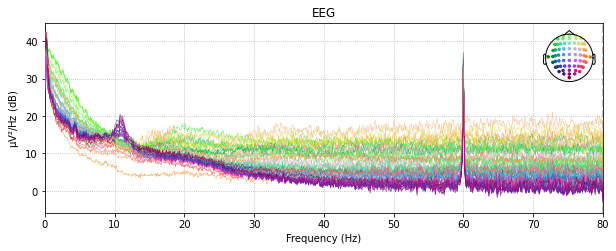

In [414]:
eeg.raw.plot_psd()

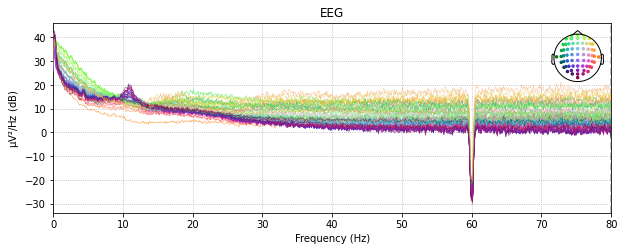

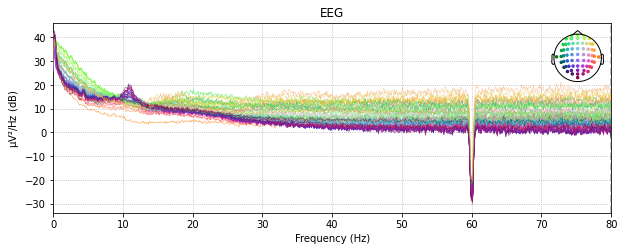

In [415]:
raw = eeg.raw.copy()
raw.notch_filter(60, filter_length='auto', phase='zero')
raw.plot_psd()

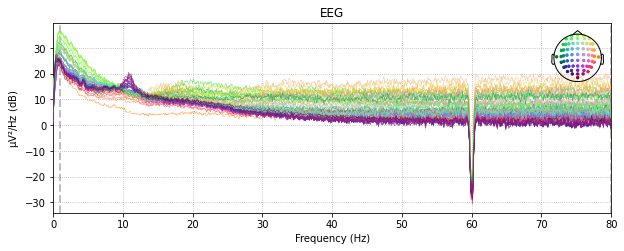

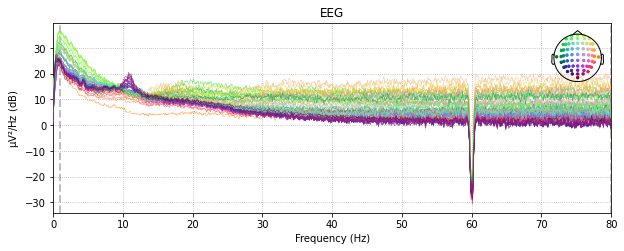

In [416]:
raw.filter(l_freq=1, h_freq=None)
raw.plot_psd()

In [417]:
ica = mne.preprocessing.ICA(n_components=16, random_state=42)
ica.fit(raw)

C:\Users\DELL\AppData\Local\Temp/ipykernel_17340/185973250.py:1: DeprecationWarning: Version 0.23 introduced max_iter="auto", setting max_iter=1000 for `fastica` and max_iter=500 for `infomax` and `picard`. The current default of max_iter=200 will be changed to "auto" in version 0.24.
  ica = mne.preprocessing.ICA(n_components=16, random_state=42)


<ICA | raw data decomposition, fit (fastica): 593280 samples, 16 components, channels used: "eeg">

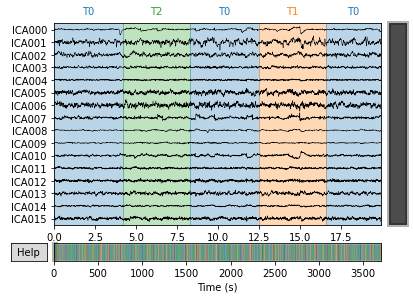

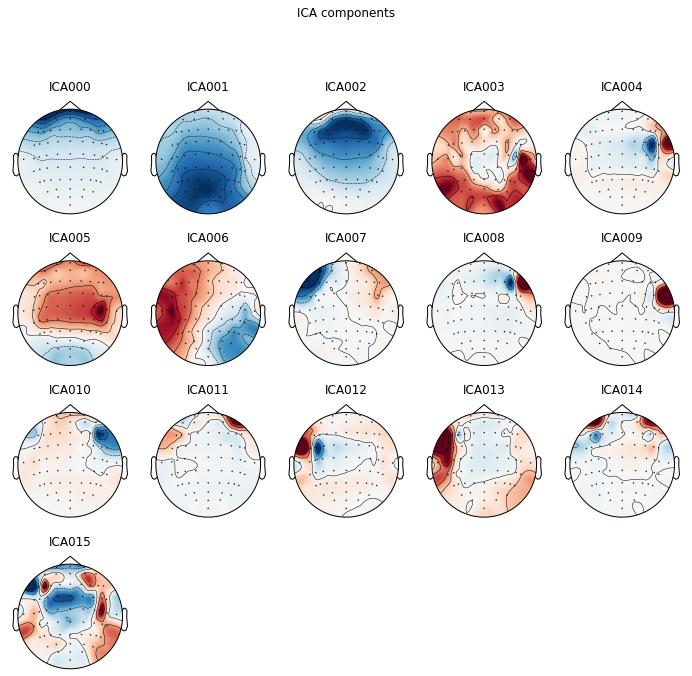

[<MNEFigure size 702x696.24 with 16 Axes>]

In [418]:
ica.plot_sources(raw)
ica.plot_components()

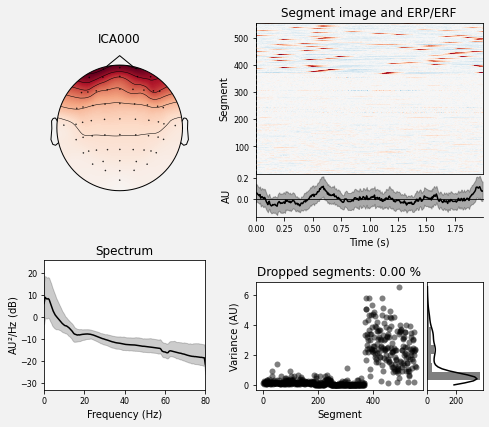

[<Figure size 504x432 with 6 Axes>]

In [75]:
ica.plot_properties(raw, picks=[0])

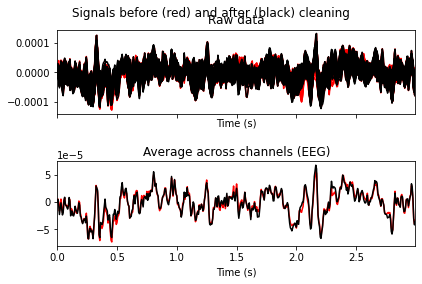

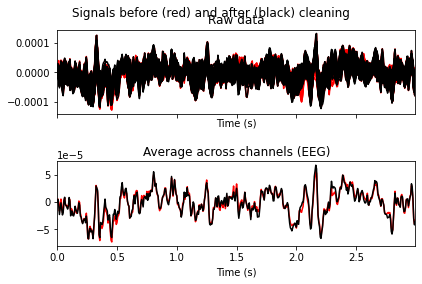

In [294]:
ica.plot_overlay(raw, exclude=[0])

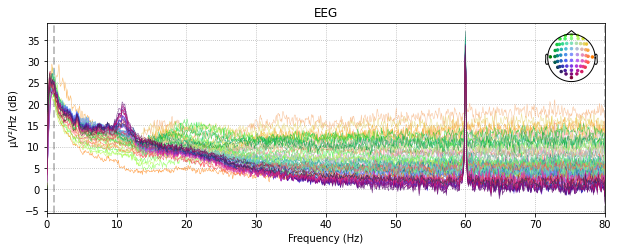

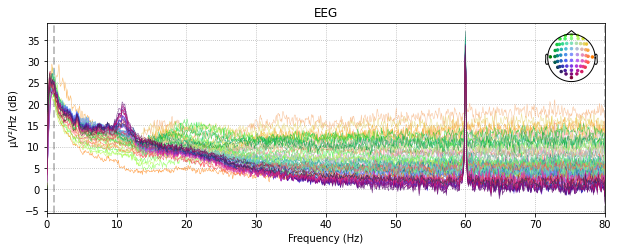

In [419]:
ica.exclude = [0]
ica.apply(eeg.raw)
del raw

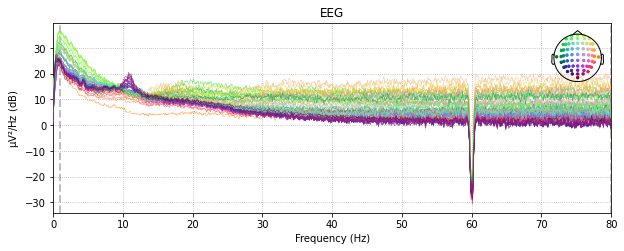

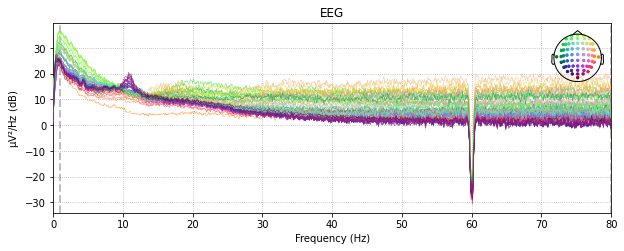

In [480]:
eeg.raw = eeg.raw.notch_filter(60, filter_length='auto', phase='zero')
eeg.apply_filter(freq=(1,None))
eeg.raw.plot_psd()

#### Time Series Data

In [481]:
X, y = eeg.get_X_y(channel_selection=False)
X.shape

(450, 64, 161)

#### Min-Max Normalization

In [459]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        time_series = X[i,j,:]
        #print(time_series.shape)
        time_series = scaler.fit_transform(time_series.reshape(-1,1))
        #print(time_series.shape)
        X[i,j,:] = time_series.squeeze()

X.shape

(450, 21, 161)

In [482]:
X_norm = (X-X.mean(axis=0))/X.std(axis=0)

### Recurrent Neural Network

**input_dim** = embedding size (length per channel)     --> timestamps<br>
**hidden_dim**   = sequence_length (no. of channels)       --> eeg channels<br>
**output_dim**   = 2 (binary classification using Softmax)

rnn in: [sentence length, batch size, embedding dim]<br>
rnn out: [sentence length, batch size, embedding dim]<br>
hn = [1, batch size, hidden dim]<br>


In [339]:
nn.RNN?

In [483]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers=2, batch_first=True)  #output size = (225, 256, 6,159)
        self.fc = nn.Sequential(nn.Linear(hidden_dim, 512), nn.ReLU(), nn.Dropout(0.1),
                                nn.Linear(512, 320), nn.ReLU(), nn.Dropout(0.1),
                               nn.Linear(320, 160), nn.ReLU(), nn.Dropout(0.1),
                               nn.Linear(160, output_dim))#, #nn.Dropout(0.1))
        
    def forward(self, x):
        # x = x.reshape(64,180,161)
        hidden_layers, hn = self.rnn(x)
        #print('hn: ', hn.shape)
        x = self.fc(hn[-1].squeeze(0))
        return x.squeeze(1)

In [484]:
net = RNN(161, 256, 2)
net = net.float()
print(net)

RNN(
  (rnn): RNN(161, 256, num_layers=2, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=320, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=320, out_features=160, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=160, out_features=2, bias=True)
  )
)


In [485]:
import torch.optim as optim

learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = net.to(device)
criterion = criterion.to(device)

In [486]:
X_tensor = torch.FloatTensor(X)
y_tensor = torch.from_numpy(y)
X_tensor.requires_grad = True
X_tensor.shape

torch.Size([450, 64, 161])

In [487]:
from torch.utils.data import TensorDataset

train_data = TensorDataset(X_tensor, y_tensor)

train_size = int(X_tensor.size()[0] * 0.7)
valid_size = int(X_tensor.size()[0] * 0.3)
#test_size = int(X_tensor.size()[0] * 0.10+1)
#print(train_size, valid_size, test_size)

print(train_size, valid_size)

#train_set, valid_set, test_set = torch.utils.data.random_split(train_data, [train_size, valid_size, test_size])
train_set, valid_set = torch.utils.data.random_split(train_data, [train_size, valid_size])

BATCH_SIZE = 45 #keeping it binary so it fits GPU

#Train set loader
train_iterator = torch.utils.data.DataLoader(dataset=train_set, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)
#Validation set loader
valid_iterator = torch.utils.data.DataLoader(dataset=valid_set, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)

#Test set loader
#test_iterator = torch.utils.data.DataLoader(dataset=test_set, 
#                                          batch_size=BATCH_SIZE, 
#                                          shuffle=True)

315 135


In [491]:
def train_model(net, dataloader, optimizer, criterion):
    epoch_loss = 0
    epoch_accuracy = []
    
    net.train()
    
    for X, y in dataloader:
        optimizer.zero_grad()
        X = Variable(X)
        y = Variable(y)
        X=X.to(device)
        y=y.to(device)
        #print(y.type())
        yhat = net(X)
        #print('X: ', X.shape)
        #print('yhat: ', yhat.shape)
        loss = criterion(yhat, y.type(torch.LongTensor))
        
        
        loss.backward()
        optimizer.step()
        
        _, yhat = torch.max(yhat.data, axis=1)
        #print(yhat)
        accuracy = torch.sum(yhat==y)/y.shape[0]
        print(f"Test accuracy: ", accuracy)
        
        epoch_loss += loss.item()
        epoch_accuracy.append(accuracy)
        
    return yhat, epoch_loss/len(dataloader), np.mean(epoch_accuracy)

In [44]:
y.astype(np.int64)

array([1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 0], dtype=int64)

In [489]:
def eval_model(net, dataloader, optimizer, criterion):
    epoch_loss = 0
    epoch_accuracy = []
    
    net.eval()
    
    for X, y in dataloader:
        
        X = Variable(X)
        y = Variable(y)
        X = X.to(device)
        y = y.to(device)
        
        yhat = net(X)
        
        loss = criterion(yhat, y.type(torch.LongTensor))
        
        _, yhat = torch.max(yhat.data, axis=1)
        accuracy = torch.sum(yhat==y)/y.shape[0]
        print(f"Validation accuracy: ", accuracy)
        
        epoch_loss += loss.item()
        epoch_accuracy.append(accuracy)
        
    return yhat, epoch_loss/len(dataloader), np.mean(epoch_accuracy)

In [1]:
n_epochs = 200
train_losses = []
valid_losses = []
train_accuracy = []
valid_accuracy = []
best_valid_loss = np.inf

for epoch in range(n_epochs):
    yhat, train_loss, train_acc = train_model(net, train_iterator, optimizer, criterion)
    yhat, valid_loss, valid_acc = eval_model(net, valid_iterator, optimizer, criterion)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracy.append(train_acc)
    valid_accuracy.append(valid_acc)
    
    if (epoch) % 10 == 0:
        clear_output(wait=True)
        print(f'Epoch: {epoch+1}')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc:.2f}%')

NameError: name 'np' is not defined

### Further Tasks

Given X and y, perform Binary Classification to correctly identify an event as T1 or T2. 

<p>T1 = Clenching Fists  (Real or imagining)</p>
T2 = Moving Feet      (Real or imagining)

**Possible methods which may be used:**
1. <s>Logistic Regression (Linearly separable data only)</s>
2. <s>State Vector Machines</s>
3. <s>Linear Discriminant Analysis</s>
4. CNN + LSTM

**We may also try Feature Engineering and Selection to improve accuracy of our model.**
1. Artifact Handling using ICA (may be better to let the deep learning model handle it)
2. <s>Common Spatial Patterns Algorithm to extract features</s>
3. <s>Using a subset of functionally-relevant Electrodes (channels)</s>
4. Applying Baseline to the training data to get less noisy signal
5. Short-time Fast Fourier Transform
6. Wavelet Transform